In [41]:
import os
import sys
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit, fsolve
cc = plt.rcParams['axes.prop_cycle'].by_key()['color']
%matplotlib inline

# Check that pwd is relaxation directory and code is compiled
if os.path.exists(os.getcwd()+'/polytropic_debug.ipynb'):
    os.chdir('../../..') # May need to be set by hand if nonconventional setup
if os.path.exists('McAstro'):
    from McAstro.utils import constants as const
    from McAstro.stars.winds import polytropic as polywind

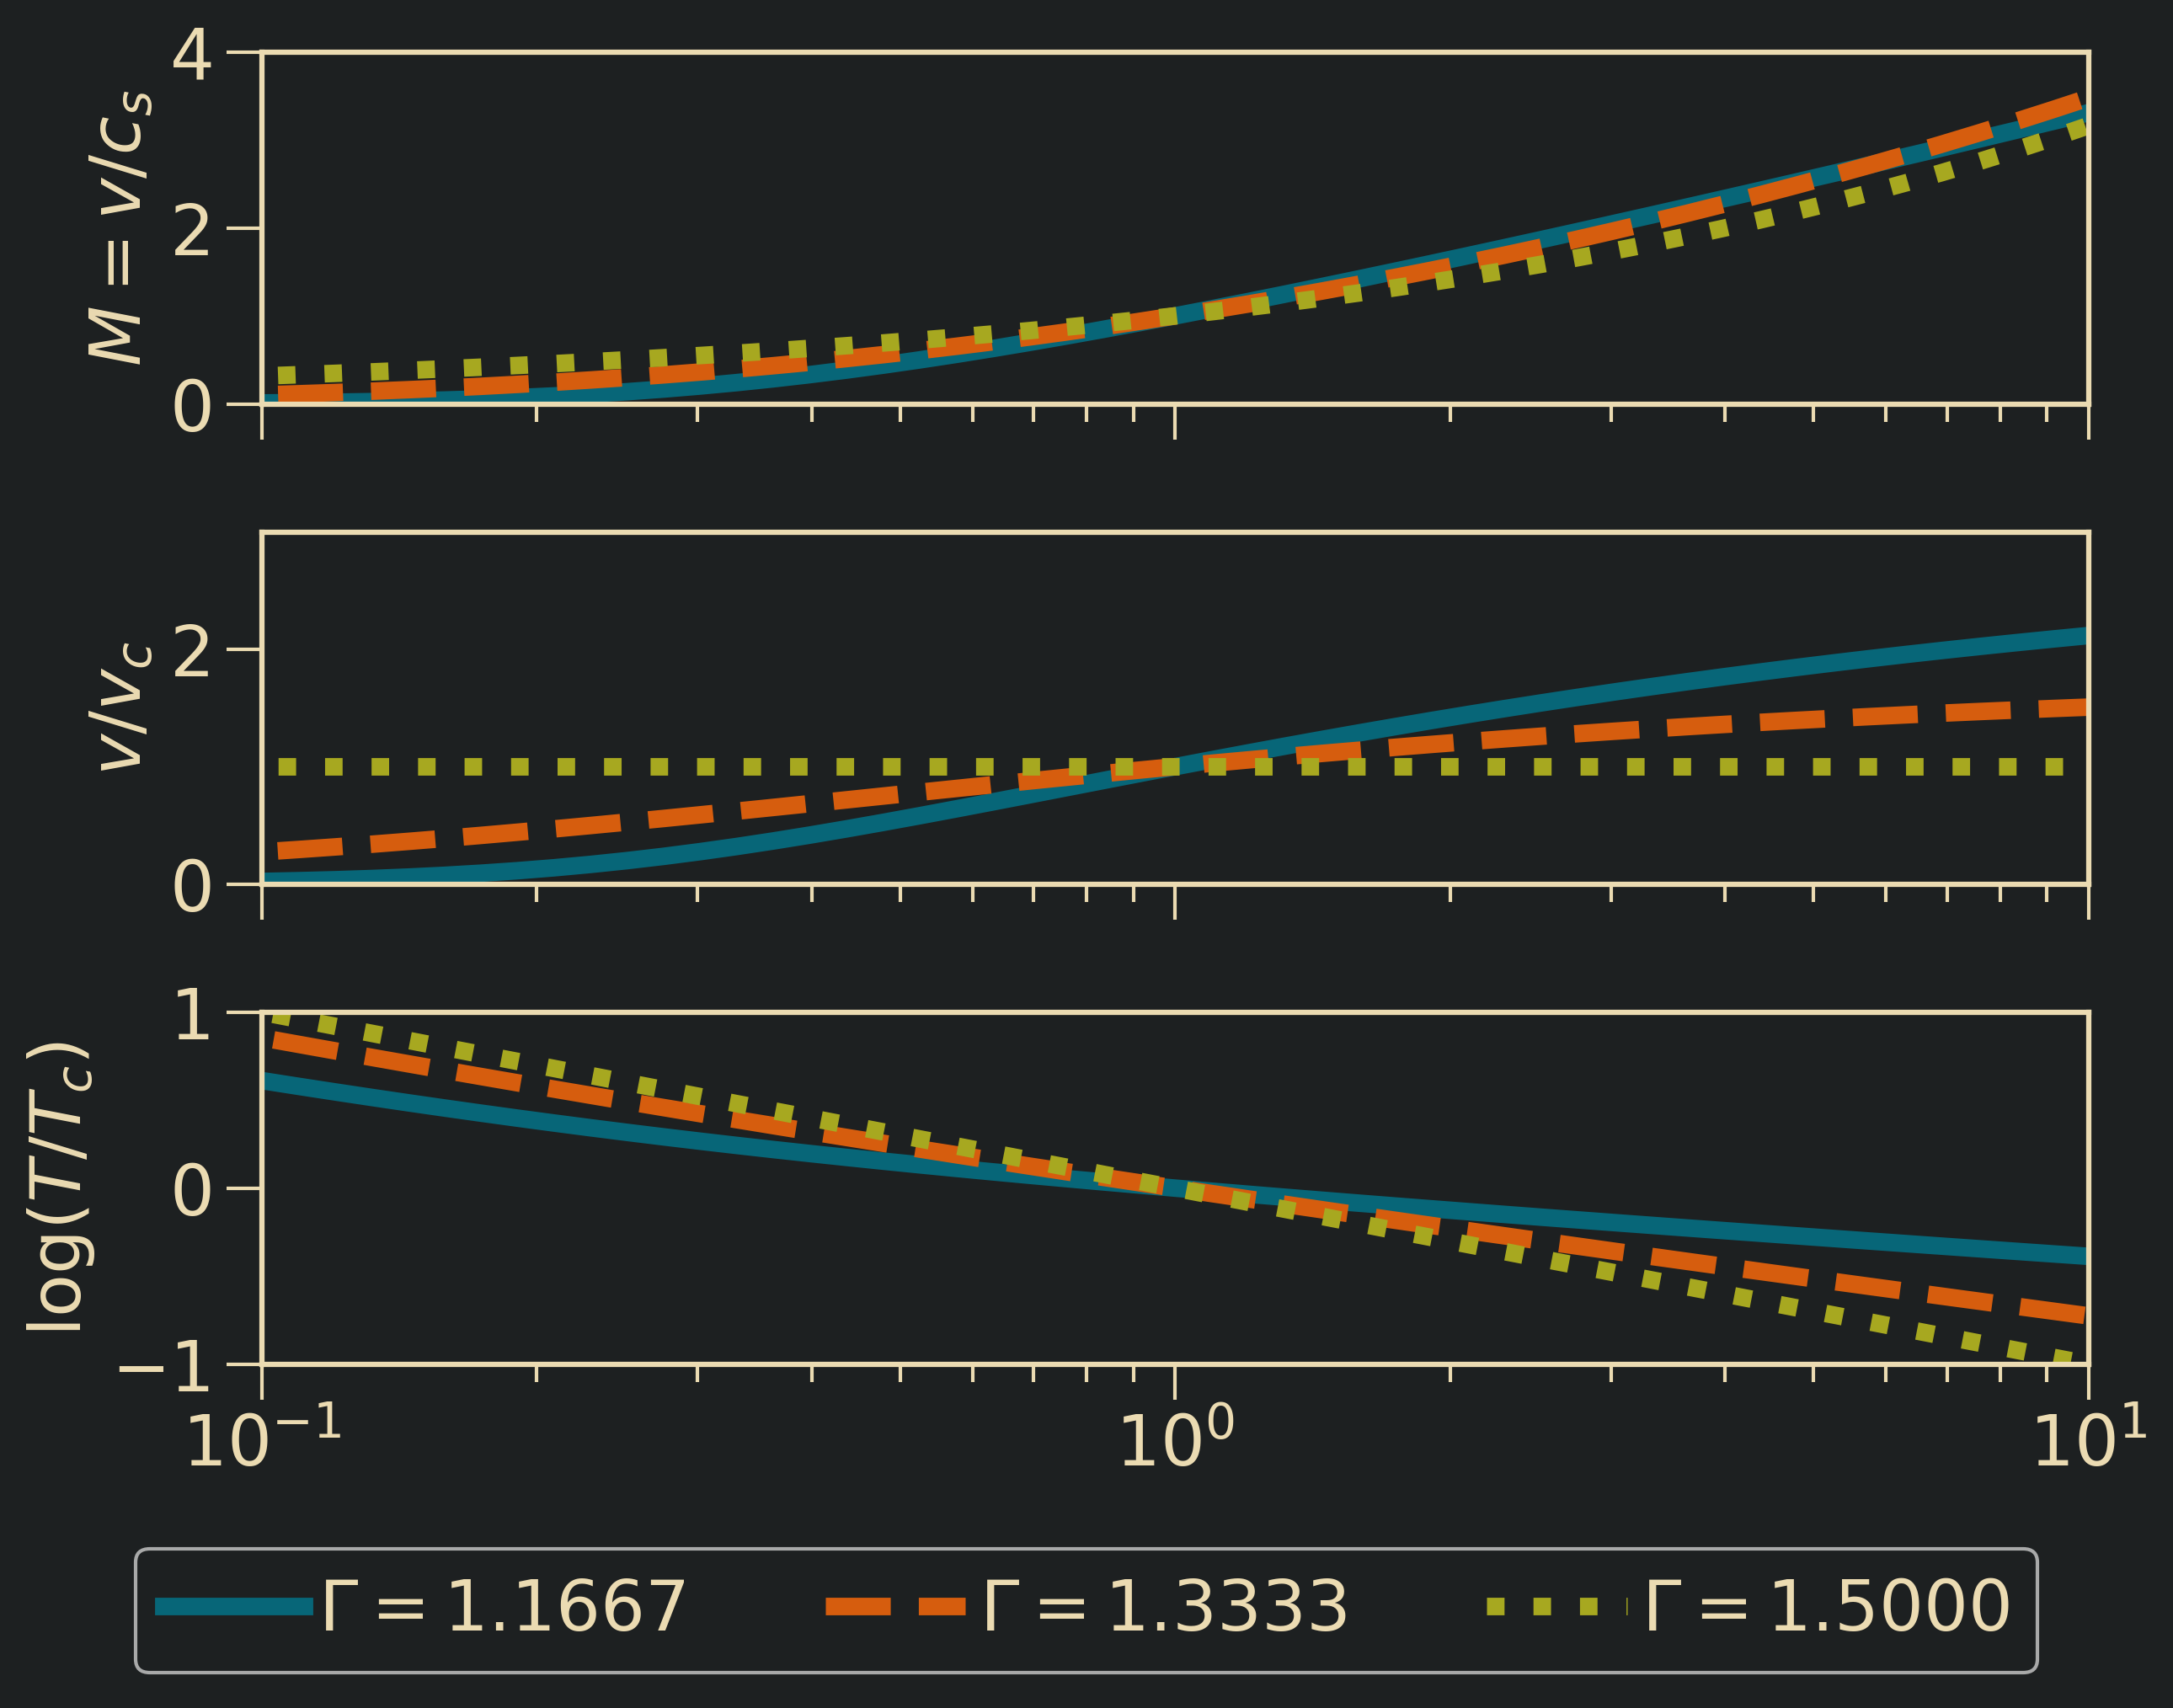

In [2]:
#Reproduce Figure 4.1 of Lamers and Cassinelli
Gamma1 = 7/6
Gamma2 = 4/3
Gamma3 = 3/2

wind1 = polywind.polytropic(Gamma1, 1, 1)
wind2 = polywind.polytropic(Gamma2, 1, 1)
wind3 = polywind.polytropic(Gamma3, 1, 1)

fig, ax = plt.subplots(3,1,sharex=True)

ax[0].plot(wind1.rad, wind1.Mach, '-', label=(r'$\Gamma={:.4f}$'
                                              .format(Gamma1)))
ax[0].plot(wind2.rad, wind2.Mach, '--', label=(r'$\Gamma={:.4f}$'
                                              .format(Gamma2)))
ax[0].plot(wind3.rad, wind3.Mach, ':', label=(r'$\Gamma={:.4f}$'
                                              .format(Gamma3)))

ax[0].set_xscale('log')
ax[0].set_xlim([.1,10])
ax[0].set_ylim([0,4])
ax[0].set_ylabel(r'$M=v/c_s$')

ax[1].plot(wind1.rad, wind1.vel, '-')
ax[1].plot(wind2.rad, wind2.vel, '--')
ax[1].plot(wind3.rad, wind3.vel, ':')

ax[1].set_ylim([0,3])
ax[1].set_ylabel(r'$v/v_c$')


ax[2].plot(wind1.rad, np.log10(wind1.T), '-')
ax[2].plot(wind2.rad, np.log10(wind2.T), '--')
ax[2].plot(wind3.rad, np.log10(wind3.T), ':')

ax[2].set_ylim([-1,1])
ax[2].set_ylabel(r'$\log(T/T_c)$')

fig.legend(loc=8, ncol=3)
fig.tight_layout()
fig.subplots_adjust(bottom=0.2)  

In [340]:
#!/bin/env python3

import numpy as np
import pandas as pd
from scipy.optimize import fsolve

from McAstro.utils import constants as const

class isentropic:
    def __init__(self, Mstar, R0, T0, v0, n0, gamma=5/3, Rmax=5, Rmin=None,
                 sonic=True):
        """
        Arguments:
            Mstar: mass of the star [g]
            R0: reference radius [cm]
            T0: temperature at the reference radius [K]
            v0: velocity at the reference radius [cm.s^{-1}]
            n0: number density of protons at reference radius [cm^{-3}]
            
        Keyword arguments:
            gamma: adiabatic index of gas
            Rmax: distance integrated to, must be greater than 1 [R0]
            sonic: if gas is sonic or not
        """
        # Store user input
        self.Mstar = Mstar
        self.R0 = R0
        self.T0 = T0
        self.v0 = v0
        self.n0 = n0
        self.gamma = gamma
        self.Rmax = Rmax
        if Rmin is None:
            self.Rmin = 1
        else:
            self.Rmin = Rmin
        self.sonic = sonic
        # Calculate derive quantities
        self.mu0 = const.mH/2.
        self.rho0 = 2.*self.n0*self.mu0
        self.P0 = 2.*self.n0*const.kB*self.T0
        self.cs0 = np.sqrt(self.gamma*self.P0/self.rho0)
        # Check if atmosphere is unbound
        self.b_min = self.bern_const(self.R0, self.v0, self.T0)
        if self.b_min < 0:
            print(f'ERROR: Atmosphere is bound, bmin:{self.b_min:.5g}')
            return
        # Setup normalized coefficients
        self.phi0 = -const.G*self.Mstar/self.R0
        self.h0 = self.gamma/(self.gamma-1)*const.kB*self.T0/self.mu0
        self.bern_A = 0.5*self.v0**2/self.phi0
        self.bern_B = self.h0/self.phi0
        self.bern_min_norm = self.b_min/self.phi0
        # Solve for normalized velocity
        l1 = np.linspace(self.Rmin, 1, int(100*(1-self.Rmin)), endpoint=False)
        l2 = np.linspace(1, self.Rmax, int(100*(self.Rmax-1))+1)
        self.radius = np.concatenate((l1, l2))
        self.velocity = np.ones(len(self.radius))
        # Not sure how to make fsolve vectorize nicely
        if self.sonic:
            factor = 1e2
        else:
            factor = 1e-2
        strt = len(l1)
        self.start = strt
        for i, r in enumerate(self.radius[strt:], start=strt):
            self.velocity[i] = fsolve(self.usolve, factor*self.velocity[i-1],
                                      args=(r))
        # Patch first cell
        self.velocity[strt] = fsolve(self.usolve, self.velocity[strt+1],
                                     args=(self.radius[strt]))
        for i, r in enumerate(self.radius[:strt][::-1]):
            self.velocity[strt-1-i] = fsolve(self.usolve,
                                             self.velocity[strt-i],
                                             args=(r))
            # Cannot integrate inwards of a critical point, so break and toss
            if ((self.sonic and 
                 self.velocity[strt-1-i] >= self.velocity[strt-i]) or
                (not self.sonic and
                 self.velocity[strt-1-i] <= self.velocity[strt-i])):
                self.velocity = self.velocity[strt-i:]
                self.radius = self.radius[strt-i:]
                self.start = i
                print("WARNING: Could not integrate all the way to Rmin.")
                break
        self.dilution = 1./(self.velocity*self.radius**2)
        # Scale velocity and radius back
        self.velocity *= self.v0
        self.radius *= self.R0
        print(f'Updated v0: {self.v0:.5g} -> {self.velocity[self.start]:.5g}')
        self.density = self.rho0*self.dilution
        # Isentropic process
        self.pressure = self.P0*self.dilution**self.gamma
        self.temperature = self.T0*self.dilution**(self.gamma-1)
        self.ram_pressure = self.density*self.velocity**2
        self.total_pressure = self.pressure + self.ram_pressure 
        self.sound_speed = np.sqrt(self.gamma*self.pressure/self.density)
        self.Mach = self.velocity/self.sound_speed
        self.bern = self.bern_const(self.radius, self.velocity,
                                    self.temperature)
        # Save solution to a dataframe
        self.soln = pd.DataFrame(
            np.column_stack([self.radius, self.velocity, self.density,
                             self.pressure, self.temperature, self.ram_pressure,
                             self.total_pressure,self.sound_speed, self.Mach,
                             self.bern]),
            columns=['r', 'v', 'rho', 'P', 'T', 'P_ram', 'P_tot', 'cs', 'M',
                     'bern'])
        # Save a normalized solution
        self.soln_norm = pd.DataFrame(
            np.column_stack([self.radius/self.R0, self.velocity/self.v0,
                             self.density/self.rho0, self.pressure/self.P0,
                             self.temperature/self.T0,
                             self.ram_pressure/self.P0,
                             self.total_pressure/self.P0,
                             self.sound_speed/self.v0, self.Mach]),
            columns=['r', 'v', 'rho', 'P', 'T', 'P_ram', 'P_tot', 'cs', 'M'])
        return


    def bern_const(self, r, v, T):
        """
        Assumes constant ionization
        """
        bern = (0.5*v**2
                +self.gamma/(self.gamma-1)*const.kB*T/self.mu0
                -const.G*self.Mstar/r)
        return bern


    def usolve(self, u, r):
        """
        Description:
            For a given u and r, returns the difference in the Bernoulli
            constant. For a given r, minimize this function to solve for the
            u(r), i.e., bern_const(r, u(r), T(r)) = bern_const(R0, v0, T0),
            where we have used a constant mass-loss rate and assumed an
            isentropic process to write T(r)in terms of u(r) and r.
        """
        return (self.bern_A*u**2
                +self.bern_B/(u*r**2)**(self.gamma-1.)
                +1/r-self.bern_min_norm)

In [357]:
# Minimum T to make du/dr > 0 at R0
const.G*tim.Mstar*tim.mu0/(10./3.*const.kB*tim.R0)/1e6
const.G*tim.Mstar*tim.mu0/(10./3.*const.kB*4.19e11)/1e6

0.23623787774879612

Updated v0: 2.5e+07 -> 2.5e+07
1.0659319672627967


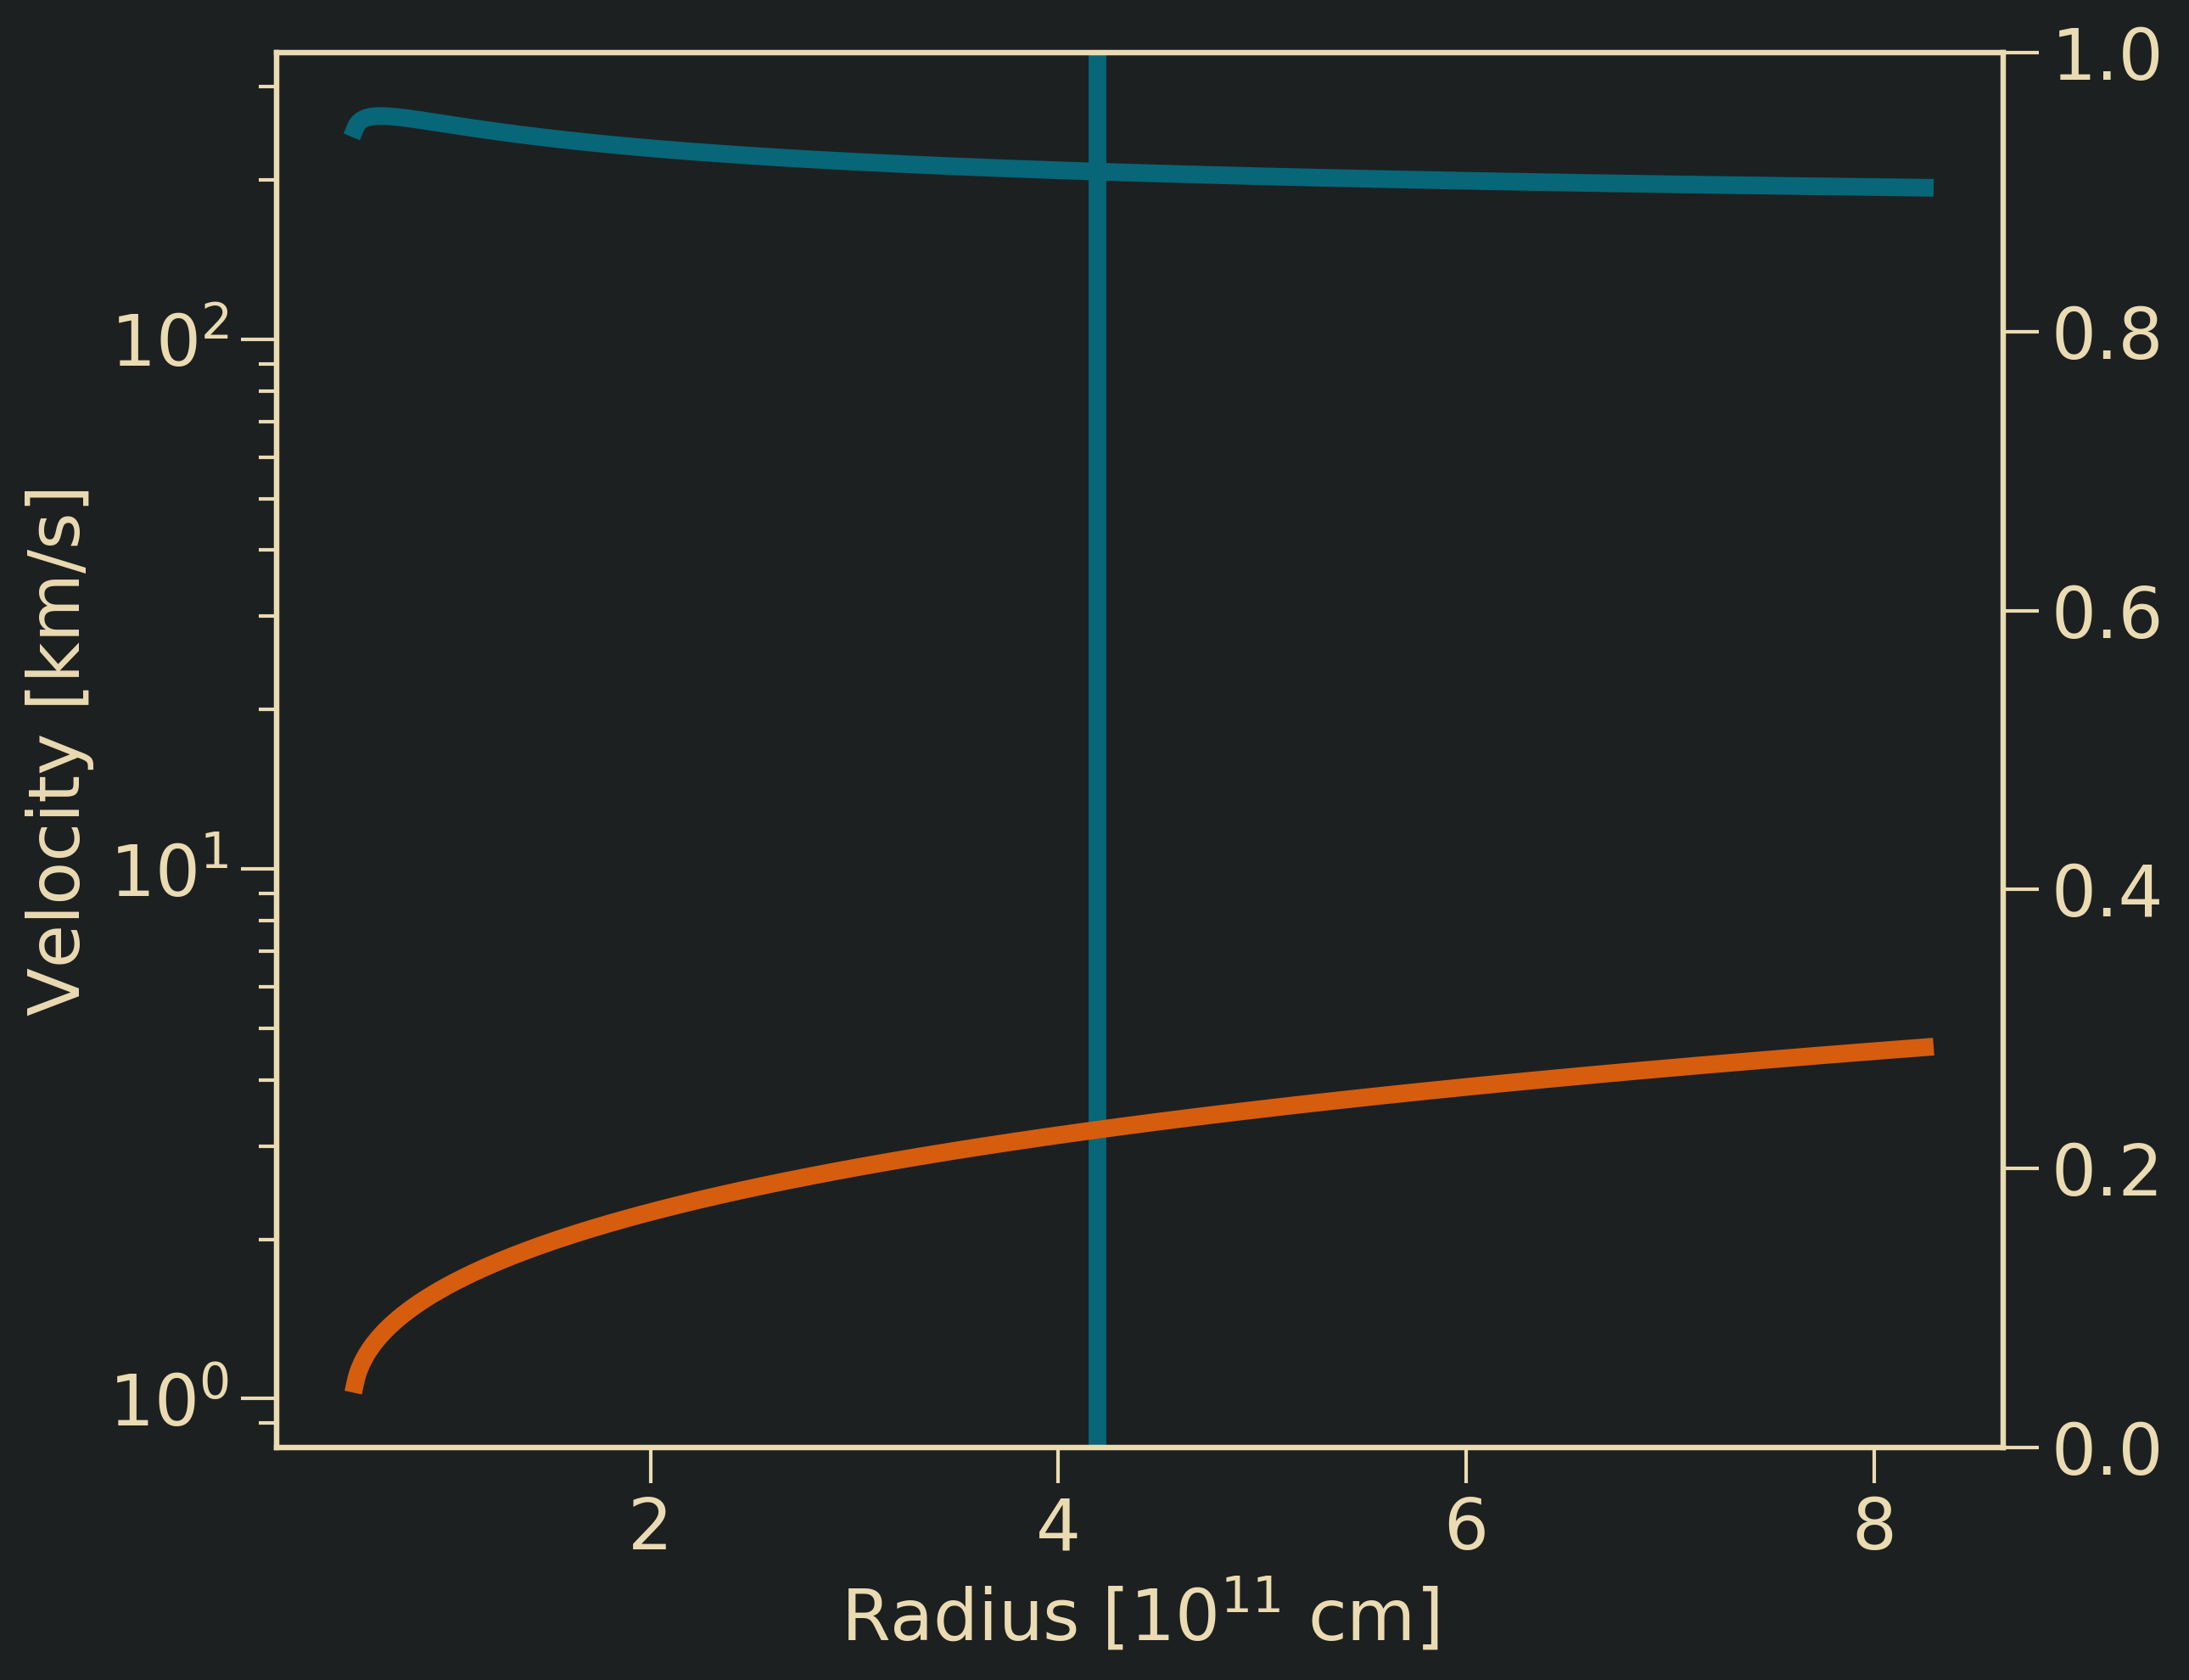

In [356]:
tim = isentropic(8.16e32, 5.5e10, 2e6, 250e5, 1e5, Rmax=15, sonic=True)
# tim = isentropic(8.16e32, 4.19e11, 2.0e6, 200e5, 4e-4, Rmax=1.1, Rmin=0.1,
#                  sonic=True)
print(tim.soln['M'][tim.start])
# tim = isentropic(8.16e32, 5.5e10, 0.41e6, 2e7, 1e5, Rmax=15)

# tim = isentropic(const.Msun, 4e11, 1.35e6, 2e7, 1e-20/const.mH, sonic=True)

fig, ax = plt.subplots()
ax.plot(tim.soln['r']/1e11, tim.soln['v']/1e5)
axb = ax.twinx()
# axb.plot(tim.soln['r']/1e12, tim.soln['T']/1e6, c=cc[1])
ax.axvline(4.19)

# tim = isentropic(8.16e32, 5.5e10, 3e6, 100e5, 4e-4, Rmax=15)
# ax.plot(tim.soln['r']/1e12, tim.soln['v']/1e5)

ax.plot(tim.soln['r']/1e11, tim.soln['M'])
# ax.axhline(tim.b_min)
ax.set_yscale('log')
ax.set_ylabel('Velocity [km/s]')
ax.set_xlabel(r'Radius [$10^{11}$ cm]')
fig.tight_layout()

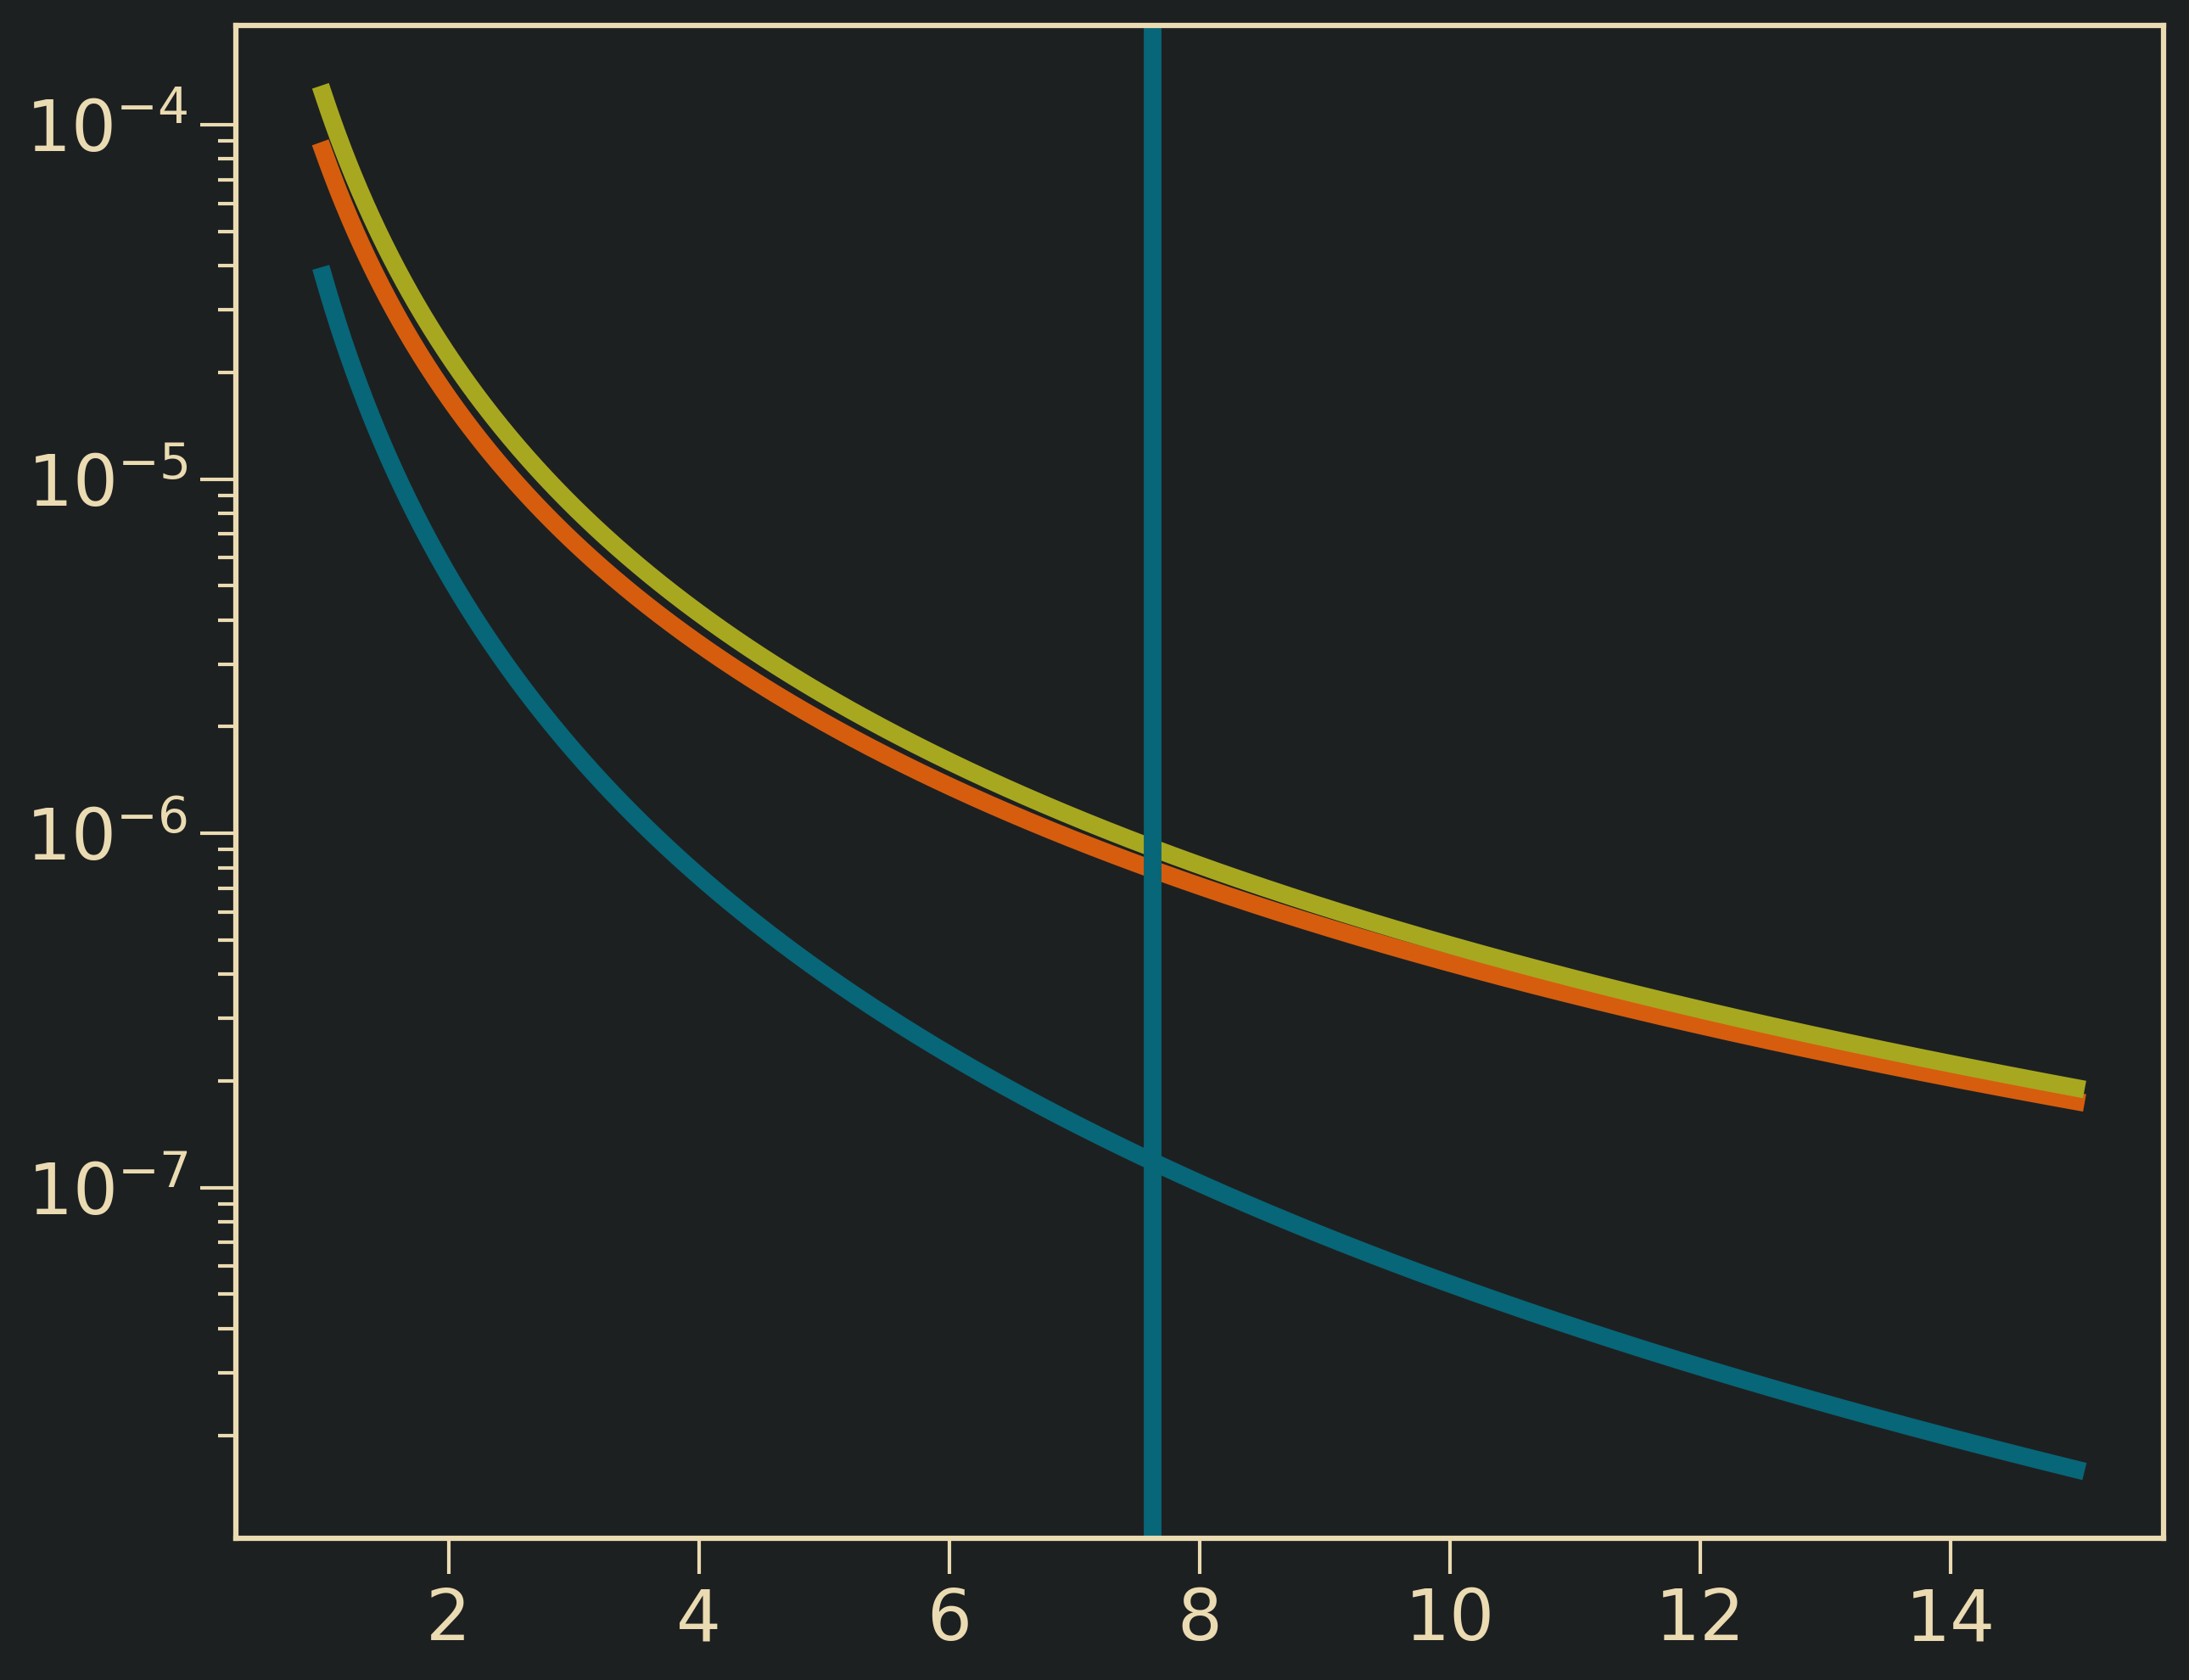

In [345]:
fig, ax = plt.subplots()
ax.plot(tim.soln_norm['r'], tim.soln['P'])
ax.plot(tim.soln_norm['r'], tim.soln['P_ram'])
ax.plot(tim.soln_norm['r'], tim.soln['P_tot'])
ax.axvline(4.19e11/tim.R0)
ax.set_yscale('log')
fig.tight_layout()